In [1]:
import pandas as pd
import numpy as np
import os
from PIL import Image
import utils
import transforms as T
import torch
import torchvision

from engine import train_one_epoch, evaluate
import utils

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler

from matplotlib import pyplot as plt

In [4]:
df = pd.read_csv("boxes.csv",index_col=False)
df_test = pd.read_csv('Boxes_test.csv',index_col=False)
class CatDataset(Dataset):

    def __init__(self, dataframe, image_dir, transforms):
        super().__init__()

        self.image_ids = dataframe['ImageID'].unique()
        self.df = dataframe
        self.image_dir = image_dir
        self.transforms = transforms

    def __getitem__(self, index: int):

        image_id = self.image_ids[index]
        records = self.df[self.df['ImageID'] == image_id]
        image = Image.open(f'{self.image_dir}/{image_id}.jpg')
        width = image.size[0]
        height= image.size[1]
        boxes = records[['XMin', 'YMin', 'XMax', 'YMax']].values

        # there is only one class
        labels = torch.ones((records.shape[0],), dtype=torch.int64)
        iscrowd = torch.zeros((records.shape[0],), dtype=torch.int64)
        # suppose all instances are not crowd
        target = {}
        target['boxes'] = torch.as_tensor(boxes).float() * torch.tensor([width,height,width,height])
        target['area'] = (target['boxes'][:,3] - target['boxes'][:,1]) * (target['boxes'][:,2]-target['boxes'][:,0])
        target['labels'] = labels
        # target['masks'] = None
        target['iscrowd'] = iscrowd
        target['image_id'] = torch.tensor([index])
        
        if self.transforms is not None:
            image, target = self.transforms(image, target)
        
        return image, target

    def __len__(self) -> int:
        return self.image_ids.shape[0]


def get_transform(train):
    transforms = []
    transforms.append(T.ToTensor())
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)


## Testing and making predictions


In [5]:
df = pd.read_csv("boxes.csv",index_col=False)
df_test = pd.read_csv('Boxes_test.csv',index_col=False)
class GetCatImage(Dataset):

    def __init__(self, dataframe, image_dir):
        super().__init__()

        self.image_ids = dataframe['ImageID'].unique()
        self.df = dataframe
        self.image_dir = image_dir

    def __getitem__(self, index: int):

        image_id = self.image_ids[index]
        records = self.df[self.df['ImageID'] == image_id]
        image = f'{self.image_dir}/{image_id}.jpg'
        
        return image

        

    def __len__(self) -> int:
        return self.image_ids.shape[0]

### Predictions pretrained model (random image) 

In [6]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True) 
def get_prediction(dataset,idx,model):
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    img, _ = dataset[idx]
    model.eval()
    with torch.no_grad():
        prediction = model([img.to(device)])

    return img, prediction
num_of_image = 7
prediction = get_prediction(CatDataset(df_test,'C:/Users/hp/fiftyone/open-images-v6/test/data', get_transform(train=True)),num_of_image,model)
print(prediction)

C:\Users\hp\anaconda3\lib\site-packages\torch\functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ..\aten\src\ATen\native\TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


(tensor([[[0.3725, 0.3882, 0.3961,  ..., 0.9882, 0.9843, 0.9843],
         [0.3922, 0.3961, 0.3922,  ..., 0.9882, 0.9882, 0.9843],
         [0.4078, 0.4000, 0.3922,  ..., 0.9922, 0.9922, 0.9922],
         ...,
         [0.2706, 0.2627, 0.2588,  ..., 0.9725, 0.9725, 0.9725],
         [0.2627, 0.2627, 0.2667,  ..., 0.9765, 0.9765, 0.9804],
         [0.2471, 0.2588, 0.2706,  ..., 0.9725, 0.9804, 0.9804]],

        [[0.2980, 0.3137, 0.3216,  ..., 0.9882, 0.9843, 0.9843],
         [0.3176, 0.3216, 0.3216,  ..., 0.9882, 0.9882, 0.9843],
         [0.3373, 0.3294, 0.3216,  ..., 0.9922, 0.9922, 0.9922],
         ...,
         [0.2353, 0.2275, 0.2235,  ..., 0.9765, 0.9765, 0.9765],
         [0.2275, 0.2275, 0.2314,  ..., 0.9804, 0.9804, 0.9765],
         [0.2118, 0.2235, 0.2353,  ..., 0.9765, 0.9765, 0.9765]],

        [[0.2431, 0.2588, 0.2667,  ..., 0.9882, 0.9843, 0.9843],
         [0.2627, 0.2667, 0.2667,  ..., 0.9882, 0.9882, 0.9843],
         [0.2824, 0.2745, 0.2667,  ..., 0.9922, 0.9922, 0

### Predictions for our trained model (same image ^^)

In [7]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(num_classes=91) # we do not specify pretrained=True, i.e. do not load default weights
model.load_state_dict(torch.load('D:/201-ICS 104/model_weightsv2.pth',map_location=torch.device('cpu')))
def get_prediction(dataset,idx,model):
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    img, _ = dataset[idx]
    model.eval()
    with torch.no_grad():
        prediction = model([img.to(device)])

    return img, prediction

img,prediction = get_prediction(CatDataset(df_test,'C:/Users/hp/fiftyone/open-images-v6/test/data', get_transform(train=True)),num_of_image,model)
print(prediction)
boxes_predicted = prediction[0]['boxes']

[{'boxes': tensor([[ 190.0391,   13.4650,  963.4845,  768.0000],
        [ 598.8385,    0.0000, 1010.8436,  768.0000]]), 'labels': tensor([17, 17]), 'scores': tensor([0.9967, 0.3418])}]


## Visualization and making bounding boxes

In [8]:
%matplotlib inline

In [9]:
import torch
import numpy as np
import matplotlib.pyplot as plt

import torchvision.transforms.functional as F


plt.rcParams["savefig.bbox"] = 'tight'


def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

C:/Users/hp/fiftyone/open-images-v6/test/data/01a471db31e88727.jpg


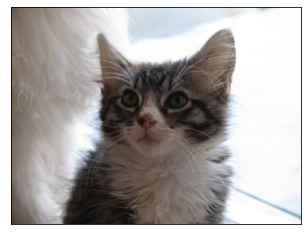

In [10]:
from torchvision.utils import make_grid
from torchvision.io import read_image
from pathlib import Path
cat_image = GetCatImage(df_test,'C:/Users/hp/fiftyone/open-images-v6/test/data')
cat_image2 = cat_image.__getitem__(num_of_image)
print(cat_image2)
cat1 = read_image(cat_image2)
grid = make_grid([cat1])
show(grid)

torch.Size([3, 768, 1024])
tensor([[190.0391,  13.4650, 963.4845, 768.0000]])


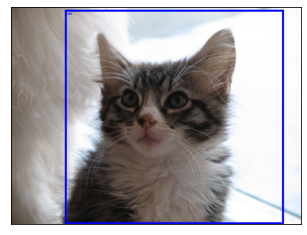

In [11]:
from torchvision.utils import draw_bounding_boxes
print(cat1.shape)
boxes = boxes_predicted[[0]]
print(boxes)

result = draw_bounding_boxes(image=cat1, 
    boxes=boxes,labels=['cat'] ,colors='blue', width=7)
show(result)

## Overall statistics and results

In [ ]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn()
device = torch.device('cuda') 
model.load_state_dict(torch.load('F:/Faster_Rcnn_Weights/model_weightsv2.pth',map_location=device))
model.to(device)
def get_prediction(dataset,idx,model,device):
    img, _ = dataset[idx]
    model.eval()
    with torch.no_grad():
        prediction = model([img.to(device)])

    return img, prediction

statdf = pd.DataFrame(columns = ["Confidence","Label"])
for i in range(895):
    img,prediction = get_prediction(CatDataset(df_test,'C:/Users/abody/fiftyone/open-images-v6/test/data', get_transform(train=True)),i,model,device)
    score = prediction[0]["scores"].data.cpu().numpy()
    label = prediction[0]["labels"].data.cpu().numpy()
    for x in range(label.size):
        if(label[x]==17):
            statdf = statdf.append({"Confidence": score[x] , "Label":label[x]}, ignore_index=True)
    print(i)

statdf.to_csv("trainingstatisticsv3.csv",index = False)

In [ ]:
import pandas as pd

def printStatistics(df):
    df["Label"] = df["Label"].apply(lambda x: "Cat" if(x==17) else "Other")
    correctRows = df["Label"] == "Cat"
    correctDf = df[correctRows]
    percentAccuracy = 100*len(correctDf.index)/len(df.index)
    numWrong = len(df.index)- len(correctDf.index)
    print("Number of Correct Classifications = ", len(correctDf.index))
    print("Number of Incorrect Classifications = ", numWrong)
    print("Percentage of Correct Classifications = ", percentAccuracy)
    averageConfidence = correctDf["Confidence"].mean()
    print("The average confidence in the correct classifications = ", averageConfidence)

In [44]:
df1 = pd.read_csv('statistics.csv')
df2 = pd.read_csv('trainingstatistics.csv')
df2["Label"]=df2["Label"].apply(lambda x: 17 if(x==1) else 1)
df3 = pd.read_csv('trainingstatisticsv2.csv')
df4 = pd.read_csv('trainingstatisticsv3.csv')
print("For the pretrained statistics: ")
printStatistics(df1)
print(100*"-")
print("For the post-trained with 2 num_classes statistics: ")
printStatistics(df2)
print(100*"-")
print("For the post-trained with 91 num_classes statistics: ")
printStatistics(df3)
print(100*"-")
print("For the post-trained with 91 num_classes and pretrained roi statistics: ")
printStatistics(df4)

For the pretrained statistics: 
Number of Correct Classifications =  811
Number of Incorrect Classifications =  84
Percentage of Correct Classifications =  90.6145251396648
The average confidence in the correct classifications =  0.9542641587895324
----------------------------------------------------------------------------------------------------
For the post-trained with 2 num_classes statistics: 
Number of Correct Classifications =  895
Number of Incorrect Classifications =  0
Percentage of Correct Classifications =  100.0
The average confidence in the correct classifications =  0.9874402920627061
----------------------------------------------------------------------------------------------------
For the post-trained with 91 num_classes statistics: 
Number of Correct Classifications =  895
Number of Incorrect Classifications =  0
Percentage of Correct Classifications =  100.0
The average confidence in the correct classifications =  0.9863157220725907
--------------------------------

In [45]:
correctRows1 = df1["Label"] == "Cat"
dfPretrained = df1[correctRows1]
correctRows2 = df4["Label"] == "Cat"
dfPosttrained = df4[correctRows2]
dfPretrained = pd.DataFrame(dfPretrained["Confidence"])
dfPretrained["Type"] = "Pretrained"
dfPosttrained = pd.DataFrame(dfPosttrained["Confidence"])
dfPosttrained["Type"] = "Posttrained"


In [46]:
combinedDf = pd.concat([dfPretrained,dfPosttrained], axis = 0)

combinedDf["Confidence"] = combinedDf["Confidence"]*100


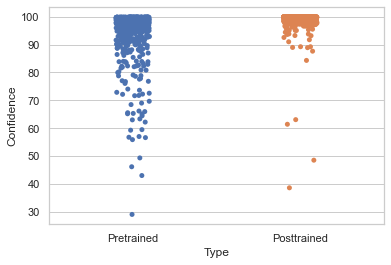

In [47]:
import seaborn as sns
sns.set_theme(style="whitegrid")
ax = sns.stripplot(x="Type", y = "Confidence", data = combinedDf )

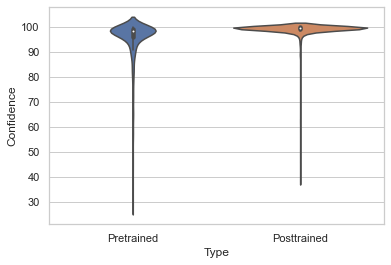

In [48]:
sns.set_theme(style="whitegrid")
ax = sns.violinplot(x="Type", y = "Confidence", data = combinedDf )